# Accessing IFT output: Julia serialized objects

The Ice Floe Tracker pipeline saves data in multiple formats. The two main formats are hdf-5 and Julia serialized objects. You can think of a `.jls` file like a Python pickle. It's a way to make the data quickly accessible in the same format it was while the computation was going on. And, like a Python pickle, it's not a format that is intended for long-term storage. That's what the hdf-5 files are for, along with CSV files. (Note: the plan is to have CSV output from the tracker module as well, but that capability has not yet been merged into main). 

You'll access the `.jls` objects using the deserialize function. 

In [1]:
using IceFloeTracker
using Images
using FileIO
using CSV
using IceFloeTracker: pairfloes, deserialize, DataFrames, colorview, RGB, PaddedView, float64, mosaicview, Gray
imshow(x) = Gray.(x);

We'll look at one of the cases where all the steps of the pipeline ran successfully (in terms of not throwing errors and crashing, not in terms of accuracy). The saved outputs are, in alphabetical order:
1. landmasks
2. preprocess ouput
   1. filenames
   2. floe_props
   3. passtimes
   4. segmented_floes
   5. timedeltas
3. soit (since this is a CSV file, I won't go over how to open it here)
4. tracked floes

In [3]:
results_loc = "../data/ift_results/baffin_bay_20240124T1406Z/baffin_bay-100km_by_100km-20070605-20070606/"

# landmasks
landmasks = deserialize(joinpath(results_loc, "landmasks/generated_landmask.jls"))

# preprocess output
fnames = deserialize(joinpath(results_loc, "preprocess/filenames.jls"));
floe_props = deserialize(joinpath(results_loc, "preprocess/floe_props.jls"));
passtimes = deserialize(joinpath(results_loc, "preprocess/passtimes.jls"));
segmented_floes = deserialize(joinpath(results_loc, "preprocess/segmented_floes.jls"));
timedeltas = deserialize(joinpath(results_loc, "preprocess/timedeltas.jls"));

# tracker output
tracked_floes = deserialize(joinpath(results_loc, "tracker/labeled_floes.jls"));

The landmask files are empty for this case. It's an object with two components, a dilated landmask and a non-dilated landmask, which you can access in the same ways as object attributes in Python: `landmasks.dilated` and `landmasks.non_dilated`. You can visualize the objects with `imshow()`. Skipping that here though since there's no land in the scene.

Names of the analyzed image files are stored, unsurprisingly, in `filenames.jls`:

In [12]:
fnames.truecolor

2-element Vector{String}:
 "20070605.terra.truecolor.250m.tiff"
 "20070605.aqua.truecolor.250m.tiff"

In [13]:
fnames.reflectance

2-element Vector{String}:
 "20070605.terra.reflectance.250m.tiff"
 "20070605.aqua.reflectance.250m.tiff"

(As a side note, I'm in the process of fixing the naming scheme in the code, because *all* the images are reflectance data. Really, the word reflectance as used here should be replaced with the word "falsecolor".)

The file `floe_props.jls` contains DataFrames with extracted features in image coordinates. That means all the values are in pixels, rather than kilometers or meters. There's one dataframe per image, so for this case there are two DataFrames. Only a handful of floes were detected, so we can see the full DataFrames here.

In [22]:
floe_props[1]

Row,area,min_row,min_col,max_row,max_col,row_centroid,col_centroid,convex_area,major_axis_length,minor_axis_length,orientation,perimeter
,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,312.0,219,17,246,34,232,26,333.0,30.0859,13.497,0.451561,72.7696
2,1737.0,41,61,93,110,66,85,1895.0,60.2734,38.2385,-0.610458,173.924
3,684.0,285,62,319,96,302,80,736.0,44.5632,19.9069,-0.757248,110.811
4,361.0,353,64,388,84,371,75,445.0,40.6058,13.0476,0.344686,93.598
5,309.0,146,74,164,100,154,88,352.0,25.7901,16.5219,1.49096,73.3553
6,458.0,313,181,338,213,325,197,548.0,30.6667,21.7126,-1.12713,99.4975
7,636.0,240,239,283,263,262,250,723.0,49.713,17.2907,-0.367014,114.912


In [23]:
floe_props[2]

Row,area,min_row,min_col,max_row,max_col,row_centroid,col_centroid,convex_area,major_axis_length,minor_axis_length,orientation,perimeter
,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,724.0,285,61,319,100,302,80,795.0,48.1073,19.7279,-0.810733,119.054
2,1706.0,39,63,92,110,64,84,1869.0,58.3102,38.8515,-0.525304,175.095
3,329.0,353,63,379,81,367,72,357.0,26.701,17.0967,0.231043,73.9411
4,629.0,241,238,284,263,262,250,736.0,49.9523,17.6437,-0.36004,116.569
5,342.0,364,253,381,286,370,271,433.0,38.2794,14.2279,1.38988,90.5269


The information from SOIT is saved in the passtimes object, a DateTime vector with length equal to the number of images.

In [25]:
passtimes

2-element Vector{DateTime}:
 2007-06-05T16:12:22
 2007-06-05T16:32:38

Next, we look at the segmented floes. As with the others, the object has an entry for each of the two analyzed images. One thing that we can see is that there are more features in these images than in the floe props; I believe that that is a function of the minarea and maxarea settings trimming the extracted features. The floe_props column entries allow you to select individual objects if wanted based on the min/max row and column information.

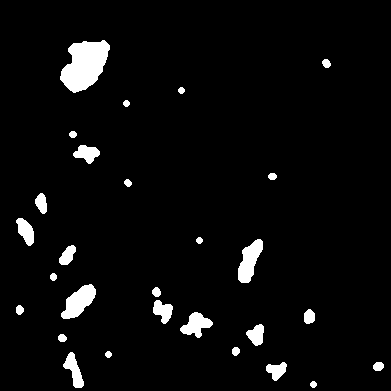

In [31]:
imshow(segmented_floes[1])

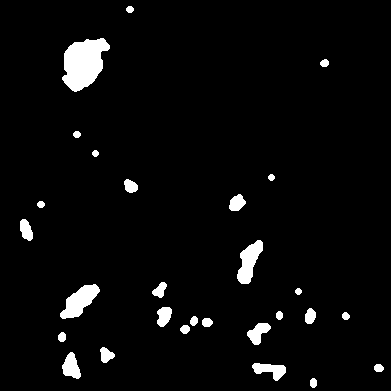

In [32]:
imshow(segmented_floes[2])

The time in seconds between each image is saved in `timedeltas`. Note that since this image has artifacts from overlapping images, it could well be the case that the real time delta in different regions of the image could be quite different.

In [33]:
timedeltas

1-element Vector{Float64}:
 20.0

The `labeled_floes.jls` object contains all the floes that were tracked between the images, and given an integer label. There are some questions about how to handle labeling and reporting trajectories for longer runs, but for now we have this. It shows that only 3 floes were tracked from one image to the next. I believe by this step, the data has already been transformed from pixel units to physical units. I'll check that in the documentation.

In [34]:
tracked_floes

Row,ID,passtime,area,convex_area,major_axis_length,minor_axis_length,orientation,perimeter,latitude,longitude,x,y,area_mismatch,corr
,Int64,DateTime,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64?
1,1,2007-06-05T16:12:22,113.618,123.953,15.4152,9.77966,-0.610458,44.4818,74.8924,-66.2229,-1.52925e6,-5.90889e5,0.0,0.993546
2,1,2007-06-05T16:32:38,111.59,122.252,14.9131,9.93644,-0.525304,44.7814,74.8929,-66.2427,-1.52874e6,-5.91145e5,missing,missing
3,2,2007-06-05T16:12:22,41.601,47.2917,12.7143,4.42218,-0.367014,29.3892,74.6897,-64.0927,-1.57938e6,-5.48689e5,0.0,0.999245
4,2,2007-06-05T16:32:38,41.1431,48.142,12.7755,4.51247,-0.36004,29.8129,74.6897,-64.0927,-1.57938e6,-5.48689e5,missing,missing
5,3,2007-06-05T16:12:22,44.7407,48.142,11.3972,5.09128,-0.757248,28.3405,75.093,-64.2534,-1.58961e6,-5.92168e5,0.0,0.985361
6,3,2007-06-05T16:32:38,47.3571,52.0012,12.3037,5.04551,-0.810733,30.4485,75.093,-64.2534,-1.58961e6,-5.92168e5,missing,missing
